# Burstiness Thresholding: Expanded Valida

This notebook extends the earlier burstiness-thresholding work with:

1. **Expanded data coverage**: We now load *all* `.npz` files recursively from:
   - Human: `data/tokens/human/reuter5050/C50train`
   - LLaMA-generated / LLaMA-scored: `data/tokens/llama70Bw4a16/reuter5050/C50train`
   - LLaMA-generated / Mixtral-scored: `data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train`

2. **Train vs Validation Split**: We do a stratified 80/20 split of human vs model docs:
   - Learn a best single-metric threshold using only the training split
   - Evaluate that fixed threshold on held-out validation data

3. **New burstiness metrics**:
   - High-frequency Fourier energy ratios (`fft_high_75`, `fft_high_90`)
   - Gabor-like localized burst energy (`gabor_max`)

4. **Two comparisons**:
   - Human vs LLaMA-generated / LLaMA-scored
   - Human vs LLaMA-generated / Mixtral-scored

The goal: test whether simple burstiness-style temporal/spectral metrics of log-probability sequences generalize as discriminators between human and model-generated text under different scorers.

In [ ]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

# Roots: recurse
HUMAN_LLAMA_ROOT    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
HUMAN_MIXTRAL_ROOT  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_ROOT_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_ROOT_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'

RNG = np.random.default_rng(42)


In [ ]:
def find_all_npz(root_dir: str) -> list[str]:
    # Recursively find all .npz files under root_dir.
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    # Return a list of log-prob arrays (float64) for every .npz file under root_dir.
    # Uses LogProbs.from_file if available, else reads 'token_probs' in the npz.
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' in npzfile:
                    probs = np.asarray(npzfile['token_probs'], dtype=np.float64)
                else:
                    raise RuntimeError(f"{p} missing 'token_probs'; cannot load without LogProbs class.")
        logp = np.log(np.clip(probs, 1e-45, 1.0))
        series.append(logp)
    return series

human_series_all       = load_logp_series_from_root(HUMAN_LLAMA_ROOT)
llm_series_all_llama   = load_logp_series_from_root(LLM_ROOT_LLAMA)
llm_series_all_mixtral = load_logp_series_from_root(LLM_ROOT_MIXTRAL)
print(f'Loaded {len(human_series_all)} human docs, '
      f'{len(llm_series_all_llama)} llama-graded docs, '
      f'{len(llm_series_all_mixtral)} mixtral-graded docs.')


Loaded 2457 human docs, 1705 llama-graded docs, 1027 mixtral-graded docs.


In [6]:
def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    # Return 2D view of rolling windows over 1D array a (drop partial tail).
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def metric_local_cv_mean(x: np.ndarray, window: int = 64, step: int = 16) -> float:
    # Mean local coefficient of variation across rolling windows.
    # CV = std / |mean| for each window, then averaged.
    w = rolling_windows(x, window, step)
    if w.size == 0:
        return np.nan
    mu = w.mean(axis=1)
    sd = w.std(axis=1, ddof=1)
    denom = np.maximum(np.abs(mu), 1e-8)
    cv = sd / denom
    return float(np.nanmean(cv))

def autocorr_abs_sum(x: np.ndarray, max_lag: int = 50) -> float:
    # Sum of |autocorr(k)| for k=1..max_lag.
    x = np.asarray(x, dtype=np.float64)
    x = x - np.mean(x)
    var = np.var(x)
    if var < 1e-14:
        return 0.0
    s = 0.0
    for k in range(1, max_lag+1):
        num = np.dot(x[:-k], x[k:]) / (x.size - k)
        s += abs(num / var)
    return float(s)

def spectral_entropy(x: np.ndarray) -> float:
    # Entropy of normalized FFT power spectrum, normalized to [0,1].
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    P = np.abs(np.fft.rfft(x))**2
    total = P.sum()
    if total <= 0:
        return 0.0
    P = P / total
    H = -np.sum(P * np.log(np.clip(P, 1e-45, 1.0)))
    return float(H / np.log(len(P)))

def var_first_diff(x: np.ndarray) -> float:
    # Variance of first difference x[t]-x[t-1].
    x = np.asarray(x, dtype=np.float64)
    if x.size < 2:
        return 0.0
    d = np.diff(x)
    return float(np.var(d))

def pot_rate(x: np.ndarray) -> float:
    # Fraction of tokens below mean-2*std for this doc.
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return 0.0
    mu = np.mean(x)
    sd = np.std(x, ddof=1) if x.size > 1 else 0.0
    thr = mu - 2.0 * sd
    return float(np.mean(x < thr))

def fano_factor_events(x: np.ndarray, bin_size: int = 64) -> float:
    # Fano factor of bursts across bins. Burst = x[t] < mean-2*std.
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return 0.0
    mu = np.mean(x)
    sd = np.std(x, ddof=1) if x.size > 1 else 0.0
    thr = mu - 2.0 * sd
    events = (x < thr).astype(np.int32)
    if events.size == 0:
        return 0.0
    n = events.size // bin_size
    if n == 0:
        return 0.0
    b = events[: n*bin_size].reshape(n, bin_size).sum(axis=1)
    m = b.mean()
    v = b.var(ddof=1) if b.size > 1 else 0.0
    return float(v / m) if m > 1e-12 else 0.0

try:
    import pywt  # type: ignore
    HAS_PYWT = True
except Exception:
    HAS_PYWT = False

def wavelet_highfreq_ratio(x: np.ndarray) -> float:
    # High-frequency wavelet energy / total wavelet energy (db4). Fallback: FFT high-band energy ratio.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    if HAS_PYWT:
        wavelet = 'db4'
        w = pywt.Wavelet(wavelet)
        max_level = pywt.dwt_max_level(len(x), w.dec_len)
        level = max(1, min(5, max_level))
        coeffs = pywt.wavedec(x, wavelet=w, level=level, mode='symmetric')
        # coeffs[0] = approx, rest = details (high-freq bands)
        e_total = np.sum([np.sum(c*c) for c in coeffs])
        e_high  = np.sum([np.sum(d*d) for d in coeffs[1:]])
        return float(e_high / e_total) if e_total > 0 else 0.0
    # Fallback: FFT split
    X = np.fft.rfft(x)
    P = (np.abs(X)**2)
    if P.sum() <= 0:
        return 0.0
    mid = P.size // 2
    e_total = P.sum()
    e_high = P[mid:].sum()
    return float(e_high / e_total)


In [7]:
def fourier_highfreq_ratio(x: np.ndarray, frac_cut: float = 0.75) -> float:
    # Ratio of energy in the top (1-frac_cut) fraction of FFT frequencies.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 0:
        return 0.0
    cut = int(np.floor(frac_cut * P.size))
    high = P[cut:].sum()
    return float(high / total)

def gabor_energy_max(x: np.ndarray, win_len: int = 64, freq_frac: float = 0.25) -> float:
    # Max localized burst energy using a Gabor-like (Gaussian * complex sinusoid) sliding window.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    n = win_len
    if x.size < n or n < 4:
        return 0.0
    t = np.arange(n)
    sigma = n / 6.0
    gauss = np.exp(-0.5 * ((t - (n-1)/2)/sigma)**2)
    omega = np.pi * freq_frac  # radians/sample, fraction of Nyquist
    carrier = np.exp(1j * omega * (t - (n-1)/2))
    gabor = gauss * carrier
    energies = []
    for start in range(0, x.size - n + 1):
        seg = x[start:start+n]
        resp = np.vdot(gabor, seg)
        energies.append(np.abs(resp)**2)
    return float(np.max(energies)) if energies else 0.0


In [ ]:
def compute_metrics_for_series(logp_list: list[np.ndarray]) -> pd.DataFrame:
    rows = []
    for idx, x in enumerate(logp_list):
        rows.append({
            'doc_id': idx,
            'cv_local_mean':       metric_local_cv_mean(x, window=64, step=16),
            'acf_abs_sum':         autocorr_abs_sum(x, max_lag=50),
            'spectral_entropy':    spectral_entropy(x),
            'var_first_diff':      var_first_diff(x),
            'pot_rate':            pot_rate(x),
            'fano_factor_events':  fano_factor_events(x, bin_size=64),
            'wavelet_hf_ratio':    wavelet_highfreq_ratio(x),
            'fft_high_75':         fourier_highfreq_ratio(x, frac_cut=0.75),
            'fft_high_90':         fourier_highfreq_ratio(x, frac_cut=0.90),
            'gabor_max':           gabor_energy_max(x, win_len=64, freq_frac=0.25),
            'n_tokens':            int(x.size),
        })
    return pd.DataFrame(rows)

# Human vs LLaMA-scored
df_h_llama = compute_metrics_for_series(human_series_all)
df_h_llama['label'] = 'human'
df_l_llama = compute_metrics_for_series(llm_series_all_llama)
df_l_llama['label'] = 'llm'
df_llama_scored = pd.concat([df_h_llama, df_l_llama], ignore_index=True)

# Human vs Mixtral-scored
df_h_mix = compute_metrics_for_series(human_series_all)
df_h_mix['label'] = 'human'
df_l_mix = compute_metrics_for_series(llm_series_all_mixtral)
df_l_mix['label'] = 'llm'
df_mixtral_scored = pd.concat([df_h_mix, df_l_mix], ignore_index=True)

print('llama_scored shape:', df_llama_scored.shape)
print('mixtral_scored shape:', df_mixtral_scored.shape)


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


llama_scored shape: (4162, 13)
mixtral_scored shape: (3484, 13)


In [18]:
def safe_auroc(y_true, scores):
    # Compute AUROC with guards for degenerate cases.
    try:
        if len(np.unique(y_true)) < 2 or len(np.unique(scores)) < 2:
            return np.nan
        return roc_auc_score(y_true, scores)
    except Exception:
        return np.nan

def evaluate_threshold(metric_values, labels, threshold, direction):
    # Evaluate a fixed threshold on a dataset.
    y_true = (labels == 'human').astype(int)
    x = metric_values.astype(float)
    if direction == '>=':
        y_pred = (x >= threshold).astype(int)
        scores = x
    else:
        y_pred = (x <= threshold).astype(int)
        scores = -x
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = safe_auroc(y_true, scores)
    cm   = confusion_matrix(y_true, y_pred, labels=[0,1])
    return dict(
        accuracy=acc,
        precision=prec,
        recall=rec,
        f1=f1,
        auroc=auc,
        confusion_matrix=cm,
        y_true=y_true,
        y_pred=y_pred,
    )

def pick_best_threshold(train_vals, train_labels, metric="macro_f1"):
    """
    Find the best (direction, threshold) on the TRAIN SPLIT ONLY.

    metric:
      - "macro_f1": maximize 0.5*(F1_human + F1_llm)
      - "f1_llm":   maximize F1 where llm is the positive class

    Returns a dict with:
      direction, threshold, score, f1_human, f1_llm, macro_f1, degenerate
    """
    x_train = train_vals.astype(float)
    y_train_str = train_labels  # array-like of "human" / "llm"

    # candidate thresholds (same logic as before)
    xs = np.sort(np.unique(x_train))
    if xs.size == 1:
        thr_list = [xs[0] - 1e-9, xs[0], xs[0] + 1e-9]
    else:
        mids = (xs[:-1] + xs[1:]) / 2.0
        thr_list = [xs[0] - 1e-9, *mids, xs[-1] + 1e-9]

    best_non_degenerate = None
    best_any = None  # fallback if everything is degenerate

    for direction in (">=", "<="):
        for thr in thr_list:
            evald = evaluate_threshold(x_train, y_train_str, thr, direction)

            y_true = evald["y_true"]  # 1 = human, 0 = llm
            y_pred = evald["y_pred"]

            # F1s per class
            f1_human = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
            f1_llm   = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
            macro_f1 = 0.5 * (f1_human + f1_llm)

            score = macro_f1 if metric == "macro_f1" else f1_llm

            # Track best_any (even if degenerate)
            cand = {
                "direction": direction,
                "threshold": float(thr),
                "score": score,
                "f1_human": f1_human,
                "f1_llm": f1_llm,
                "macro_f1": macro_f1,
                "degenerate": (len(np.unique(y_pred)) < 2),
            }
            if (best_any is None) or (cand["score"] > best_any["score"]):
                best_any = cand

            # Only consider non-degenerate for preferred result
            if cand["degenerate"]:
                continue
            if (best_non_degenerate is None) or (cand["score"] > best_non_degenerate["score"]):
                best_non_degenerate = cand

    # Prefer a non-degenerate threshold if we found one.
    if best_non_degenerate is not None:
        return best_non_degenerate
    else:
        # Fallback: return best degenerate threshold instead of None.
        # This makes the pipeline not crash, and lets you SEE that it's degenerate.
        return best_any


In [19]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    # Return (train_df, val_df) with stratified split on df_in['label'].
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    return (
        df_in.iloc[train_idx].reset_index(drop=True),
        df_in.iloc[val_idx].reset_index(drop=True),
    )

metrics_to_use = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]


In [21]:
train_llama, val_llama = stratified_train_val_split(df_llama_scored, test_size=0.2, seed=42)
rows_llama = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    picked = pick_best_threshold(
        train_llama[m].values,
        train_llama["label"].values,
        metric="macro_f1",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_llama[m].values,
        train_llama["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_llama[m].values,
        val_llama["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_llama.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_llama = (
    pd.DataFrame(rows_llama)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_llama


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,wavelet_hf_ratio,<=,4.476552e-33,False,0.725143,0.742159,0.818830,0.778611,0.778611,0.637624,0.708117,0.685200,0.703481,0.740668,0.766260,0.753247,0.753247,0.628571,0.690909,0.691000
1,cv_local_mean,<=,1.382330e-16,False,0.661160,0.648247,0.931298,0.764411,0.764411,0.396791,0.580601,NaN,0.666267,0.653295,0.926829,0.766387,0.766387,0.415966,0.591176,0.753526
2,gabor_max,<=,4.095108e-32,False,0.592971,0.618677,0.809160,0.701213,0.701213,0.361752,0.531483,0.548370,0.588235,0.618442,0.790650,0.694023,0.694023,0.370642,0.532333,0.553194
3,fft_high_75,<=,5.382568e-35,False,0.512767,0.602756,0.511959,0.553660,0.553660,0.463624,0.508642,0.489530,0.515006,0.602326,0.526423,0.561822,0.561822,0.456989,0.509406,0.505549
4,spectral_entropy,>=,6.328796e-32,False,0.507059,0.595406,0.514504,0.552007,0.552007,0.452087,0.502047,0.510007,0.500600,0.590047,0.506098,0.544858,0.544858,0.446809,0.495833,0.485278
5,fft_high_90,>=,1.402137e-35,False,0.515771,0.610381,0.496692,0.547699,0.547699,0.478992,0.513345,0.515071,0.495798,0.591837,0.471545,0.524887,0.524887,0.462916,0.493901,0.503636
6,var_first_diff,>=,-1.000000e-09,True,0.590267,0.590267,1.000000,0.742350,0.742350,0.000000,0.371175,NaN,0.590636,0.590636,1.000000,0.742642,0.742642,0.000000,0.371321,NaN
7,acf_abs_sum,>=,-1.000000e-09,True,0.590267,0.590267,1.000000,0.742350,0.742350,0.000000,0.371175,NaN,0.590636,0.590636,1.000000,0.742642,0.742642,0.000000,0.371321,NaN


### Interpretation of Threshold Results

The results suggest that some metrics show weak but nontrivial predictive power, while others fail to meaningfully separate human from LLM-generated text.  This is in contrast to our initial "Aaron Pressman" exploration, where we saw **great** separation.  So while there was a clear signal difference between the "real Aaron" vs "fake Aaron", the separation is far less clear when looking at all writers in this corpus.

- **Top performers:**  
  - `wavelet_hf_ratio` and `cv_local_mean` both achieved *moderate validation F₁-scores* (~0.69 and ~0.59 macro-F₁) with consistent train–val behavior, suggesting they capture real—but limited—signal related to the temporal or spectral structure of log probabilities.  
  - These metrics may reflect that human texts contain more localized bursts of unpredictability (wavelet energy) and greater variability in short-term structure (CV).

- **Marginal metrics:**  
  - `gabor_max` and `fft_high_75` performed near chance (macro-F₁ ≈ 0.53–0.55), implying minimal discriminative value.  
  - Their thresholds yield only small separations, and validation results closely mirror training, consistent with low but genuine separability.

- **Non-predictive metrics:**  
  - `spectral_entropy`, `fft_high_90`, and especially `var_first_diff` and `acf_abs_sum` appear effectively **uninformative**.  
  - The latter two are *degenerate thresholds*, meaning they predicted only one class (always “human”), producing artificially high recall but zero precision for LLM texts and macro-F₁ ≈ 0.37.

- **Overall conclusion:**  
  These thresholds indicate **weak-to-moderate predictive signal** in a few burstiness metrics—particularly wavelet- and variance-based measures—but not strong standalone classifiers.  
  The consistency across train and validation suggests the observed performance is genuine rather than overfit, yet the relatively low F₁ and AUROC values imply that **burstiness features alone are insufficient** for robust discrimination.  
  Combining them in a multivariate classifier (e.g., Random Forest or Logistic Regression) may reveal whether they carry complementary information beyond single-threshold separability.



[LLAMA-GRADED] Metric: wavelet_hf_ratio
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[209 132]
 [115 377]]


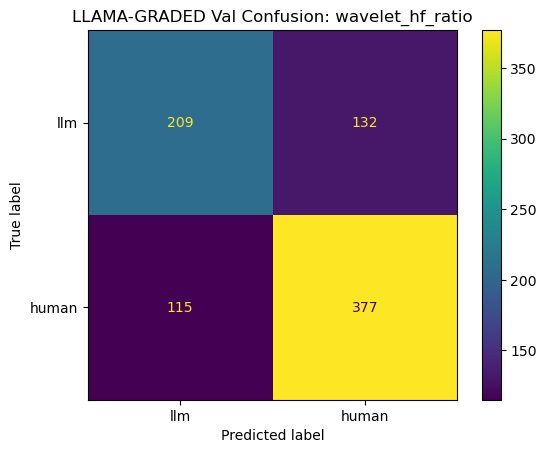


[LLAMA-GRADED] Metric: cv_local_mean
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 99 242]
 [ 36 456]]


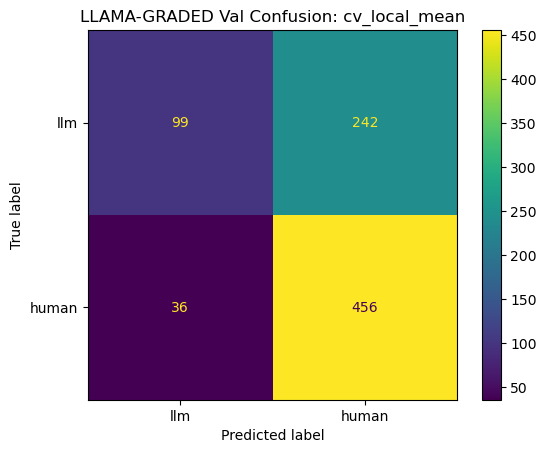


[LLAMA-GRADED] Metric: gabor_max
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[101 240]
 [103 389]]


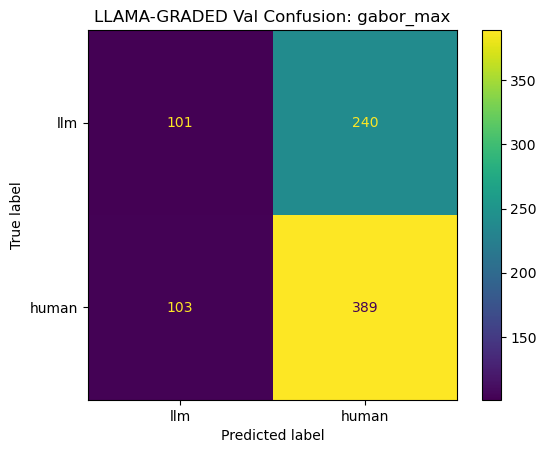


[LLAMA-GRADED] Metric: fft_high_75
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[170 171]
 [233 259]]


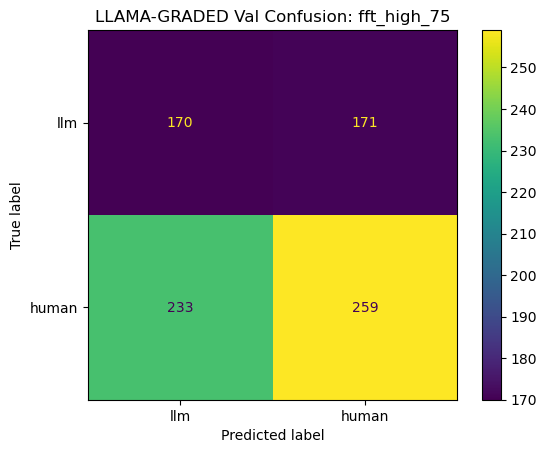


[LLAMA-GRADED] Metric: spectral_entropy
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[168 173]
 [243 249]]


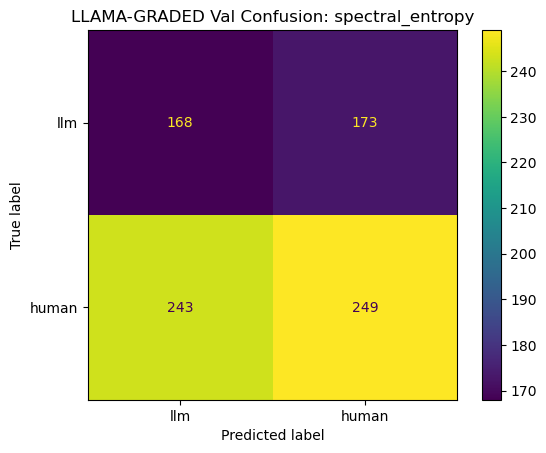


[LLAMA-GRADED] Metric: fft_high_90
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[181 160]
 [260 232]]


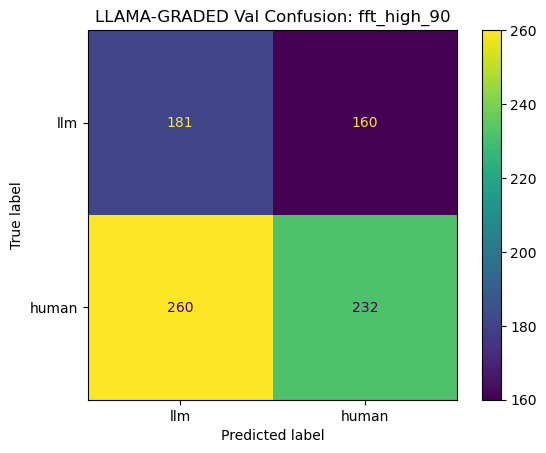


[LLAMA-GRADED] Metric: var_first_diff
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[  0 341]
 [  0 492]]


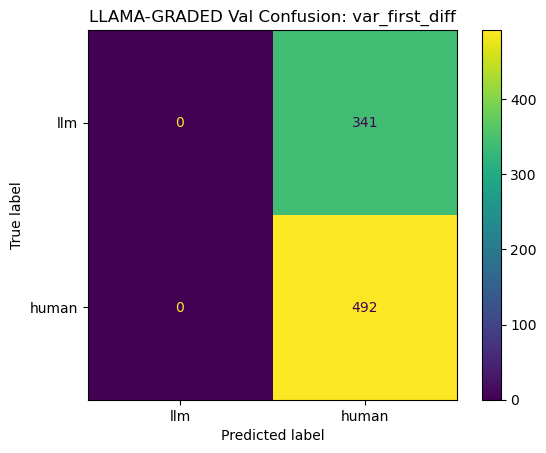


[LLAMA-GRADED] Metric: acf_abs_sum
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[  0 341]
 [  0 492]]


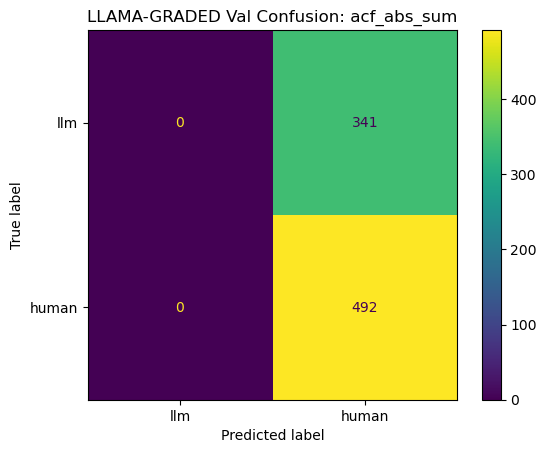

In [23]:
for i, row in results_llama.iterrows():
    m = row['metric']
    picked_dir = row['direction']
    thr = row['threshold']
    val_eval = evaluate_threshold(
        val_llama[m].values,
        val_llama['label'].values,
        thr,
        picked_dir,
    )
    cm = val_eval['confusion_matrix']
    print(f"\n[LLAMA-GRADED] Metric: {m}")
    print('Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['llm','human'])
    disp.plot(values_format='d')
    plt.title(f'LLAMA-GRADED Val Confusion: {m}')
    plt.show()


## Random Forest Classifier
Let's mash all of these thresholds up as features in a RFC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_llama["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_llama[features].values
y_train = le.transform(train_llama["label"].values)

X_val = val_llama[features].values
y_val = le.transform(val_llama["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


In [30]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.765 ± 0.013
  precision_macro:0.765 ± 0.015
  recall_macro:   0.742 ± 0.014
  f1_macro:       0.747 ± 0.014


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
# === Validation predictions ===
y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]  # probability of class "1" (should correspond to 'human')

val_accuracy  = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="binary", zero_division=0)
val_recall    = recall_score(y_val, y_val_pred, average="binary", zero_division=0)
val_f1        = f1_score(y_val, y_val_pred, average="binary", zero_division=0)

# macro scores treat human and llm symmetrically:
val_precision_macro = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
val_recall_macro    = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
val_f1_macro        = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

# AUROC (for human vs llm). We need to be careful: roc_auc_score expects scores for the "1" class.
try:
    val_auroc = roc_auc_score(y_val, y_val_proba)
except ValueError:
    val_auroc = np.nan  # happens if only one class present

print("Validation performance (held-out):")
print(f"  accuracy:         {val_accuracy:.3f}")
print(f"  precision (bin):  {val_precision:.3f}")
print(f"  recall (bin):     {val_recall:.3f}")
print(f"  f1 (bin):         {val_f1:.3f}")
print(f"  precision_macro:  {val_precision_macro:.3f}")
print(f"  recall_macro:     {val_recall_macro:.3f}")
print(f"  f1_macro:         {val_f1_macro:.3f}")
print(f"  AUROC (human=1):  {val_auroc:.3f}")

Validation performance (held-out):
  accuracy:         0.762
  precision (bin):  0.753
  recall (bin):     0.625
  f1 (bin):         0.683
  precision_macro:  0.760
  recall_macro:     0.741
  f1_macro:         0.746
  AUROC (human=1):  0.830


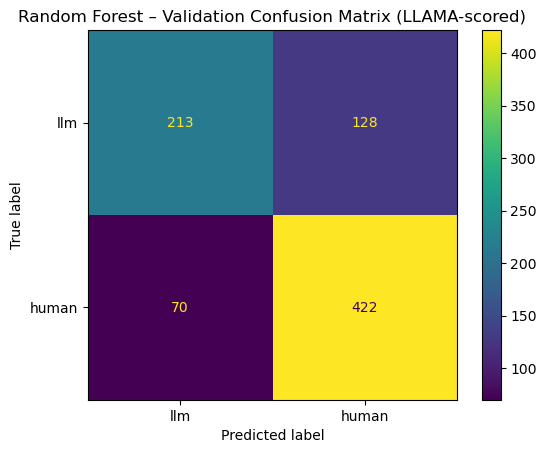

Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:
[[213 128]
 [ 70 422]]


In [32]:
cm = confusion_matrix(y_val, y_val_pred, labels=[le.transform(["llm"])[0], le.transform(["human"])[0]])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["llm", "human"],
)
disp.plot(values_format="d")
plt.title("Random Forest – Validation Confusion Matrix (LLAMA-scored)")
plt.show()

print("Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:")
print(cm)

## That's actually not bad!
We've improved over the single best metric (wavelet_hf_ratio) by 0.06 macro F1 score, from 0.69 to 0.75.  While not a clear home run, it shows that there is improvement to be gained by looking at more signal properties.  The fact that the wavelet metrics are #1 and #3 also appear to indicate the signal frequency analysis approach has some merit.

# Llama-Generated, Mixtral-Graded
Let's look at HGLG vs LGMG (Human-Generated, Llama-Graded vs Llama-Generated, Mixtral-Graded)

In [25]:
train_mix, val_mix = stratified_train_val_split(df_mixtral_scored, test_size=0.2, seed=42)
rows_mix = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    picked = pick_best_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        metric="macro_f1",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_mix.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_mixtral = (
    pd.DataFrame(rows_mix)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_mixtral


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,cv_local_mean,>=,1.382330e-16,False,0.686042,0.714905,0.922646,0.805599,0.805599,0.184529,0.495064,NaN,0.680057,0.713831,0.912602,0.801070,0.801070,0.183150,0.492110,NaN
1,gabor_max,>=,8.190217e-33,False,0.597775,0.711000,0.723664,0.717276,0.717276,0.303294,0.510285,0.506752,0.576758,0.700611,0.699187,0.699898,0.699898,0.282238,0.491068,0.482253
2,wavelet_hf_ratio,>=,2.624881e-33,False,0.584499,0.717755,0.676845,0.696700,0.696700,0.340547,0.518623,0.495415,0.552367,0.695652,0.650407,0.672269,0.672269,0.294118,0.483193,0.469225
3,fft_high_75,>=,6.567125e-38,False,0.583782,0.709745,0.693130,0.701339,0.701339,0.313609,0.507474,0.513384,0.553802,0.693790,0.658537,0.675704,0.675704,0.285057,0.480381,0.485242
4,fft_high_90,>=,2.511117e-38,False,0.583782,0.710843,0.690585,0.700568,0.700568,0.317647,0.509107,0.515580,0.553802,0.693790,0.658537,0.675704,0.675704,0.285057,0.480381,0.490546
5,spectral_entropy,>=,3.398057e-33,False,0.582705,0.710609,0.688550,0.699406,0.699406,0.317889,0.508647,0.514891,0.552367,0.693133,0.656504,0.674322,0.674322,0.284404,0.479363,0.474871
6,var_first_diff,>=,-1.000000e-09,True,0.705059,0.705059,1.000000,0.827020,0.827020,0.000000,0.413510,NaN,0.705882,0.705882,1.000000,0.827586,0.827586,0.000000,0.413793,NaN
7,acf_abs_sum,>=,-1.000000e-09,True,0.705059,0.705059,1.000000,0.827020,0.827020,0.000000,0.413510,NaN,0.705882,0.705882,1.000000,0.827586,0.827586,0.000000,0.413793,NaN


##  Llama-Generated, Mixtral-Graded 
Interestingly, there appears to be zero predictive power here, which is unfortunate.  This appears to indicate that if these results are valid, then we might only be able to detect text generated by llama using these thresholds. 


[MIXTRAL-GRADED] Metric: cv_local_mean
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 25 180]
 [ 43 449]]


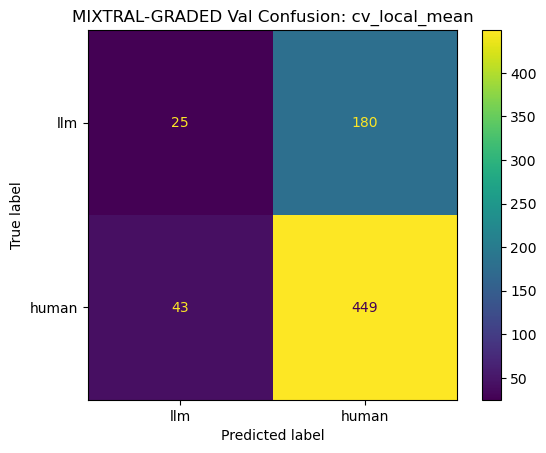


[MIXTRAL-GRADED] Metric: gabor_max
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 58 147]
 [148 344]]


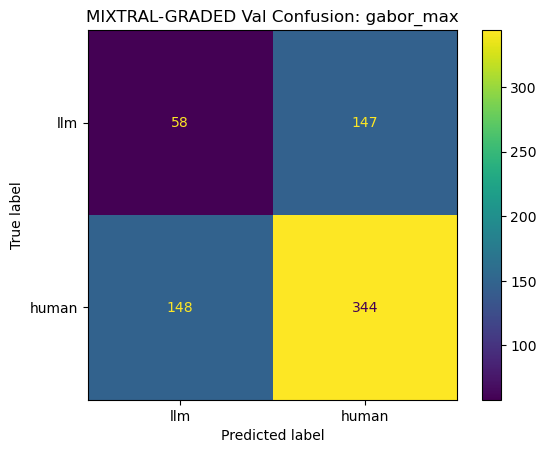


[MIXTRAL-GRADED] Metric: wavelet_hf_ratio
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 65 140]
 [172 320]]


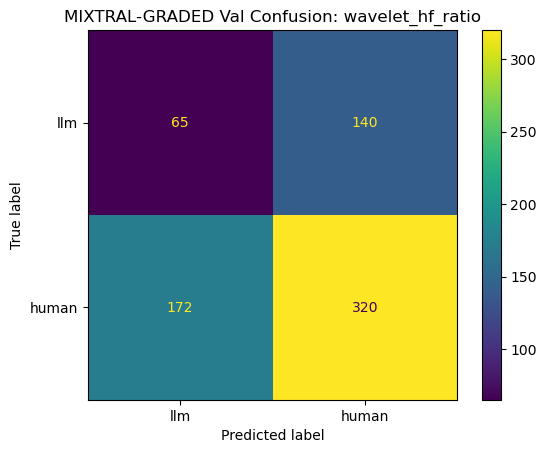


[MIXTRAL-GRADED] Metric: fft_high_75
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 62 143]
 [168 324]]


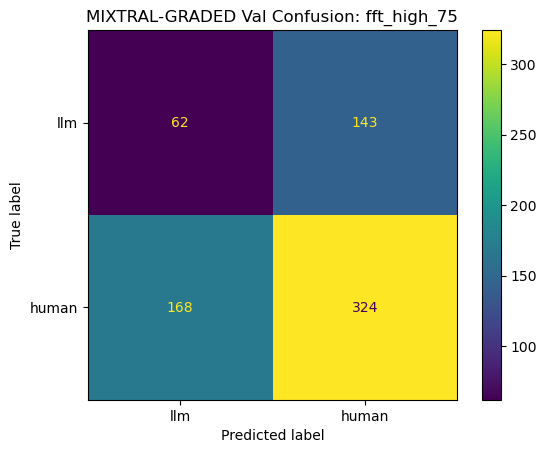


[MIXTRAL-GRADED] Metric: fft_high_90
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 62 143]
 [168 324]]


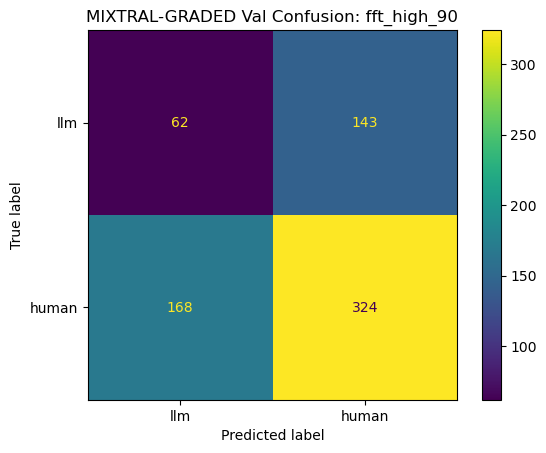


[MIXTRAL-GRADED] Metric: spectral_entropy
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 62 143]
 [169 323]]


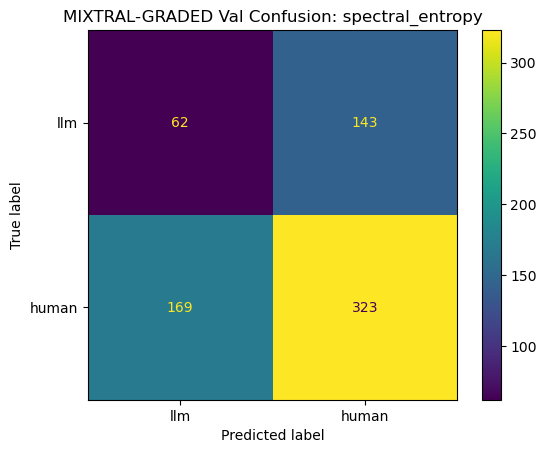


[MIXTRAL-GRADED] Metric: var_first_diff
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[  0 205]
 [  0 492]]


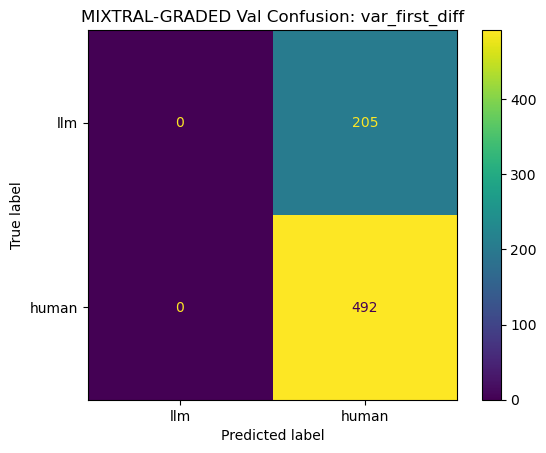


[MIXTRAL-GRADED] Metric: acf_abs_sum
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[  0 205]
 [  0 492]]


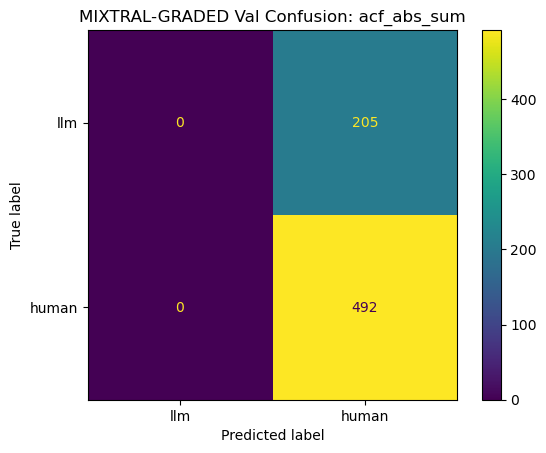

In [26]:
for i, row in results_mixtral.iterrows():
    m = row['metric']
    picked_dir = row['direction']
    thr = row['threshold']
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix['label'].values,
        thr,
        picked_dir,
    )
    cm = val_eval['confusion_matrix']
    print(f"\n[MIXTRAL-GRADED] Metric: {m}")
    print('Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['llm','human'])
    disp.plot(values_format='d')
    plt.title(f'MIXTRAL-GRADED Val Confusion: {m}')
    plt.show()


In [ ]:
def plot_metric_histograms(df_in: pd.DataFrame, metrics: list[str], title_prefix: str):
    # Overlapping histograms for human vs llm per metric.
    for m in metrics:
        fig = plt.figure()
        hvals = df_in.loc[df_in.label=='human', m].dropna().values
        lvals = df_in.loc[df_in.label=='llm',   m].dropna().values
        plt.hist(hvals, bins=20, alpha=0.5, density=True, label='human')
        plt.hist(lvals, bins=20, alpha=0.5, density=True, label='llm')
        plt.axvline(np.median(hvals), linestyle='--')
        plt.axvline(np.median(lvals), linestyle=':')
        plt.xlabel(m)
        plt.ylabel('Density')
        plt.legend()
        plt.title(f'{title_prefix}: {m}')
        plt.show()

plot_metric_histograms(df_llama_scored, metrics_to_use, 'LLAMA-GRADED Histogram')
plot_metric_histograms(df_mixtral_scored, metrics_to_use, 'MIXTRAL-GRADED Histogram')


## Random Forest Classifier for LGMG vs HGLG
Llama-generated, Mixtral-graded vs Human-generated, Llama-graded

In [33]:

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_mix["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_mix[features].values
y_train = le.transform(train_mix["label"].values)

X_val = val_mix[features].values
y_val = le.transform(val_mix["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


In [34]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.671 ± 0.015
  precision_macro:0.547 ± 0.029
  recall_macro:   0.525 ± 0.015
  f1_macro:       0.512 ± 0.017


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## It appears we are at a coin toss for LGMG
This doesn't appear worth pursuing at this point

## One more thing I'd like to check : HGMG vs LGMG
We haven't looked at the Mixtral log probs for the human text.  Let's see if there is a difference between HGMG and LGMG

In [36]:
HUMAN_MIXTRAL_ROOT  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
human_mixtral_series_all       = load_logp_series_from_root(HUMAN_MIXTRAL_ROOT)
print(f'Loaded {len(human_mixtral_series_all)} human docs, '
      f'{len(llm_series_all_mixtral)} mixtral-graded docs.')

Loaded 2499 human docs, 1027 mixtral-graded docs.


In [38]:
df_h_mix = compute_metrics_for_series(human_mixtral_series_all)
df_h_mix['label'] = 'human'
df_l_mix = compute_metrics_for_series(llm_series_all_mixtral)
df_l_mix['label'] = 'llm'
df_mix_scored = pd.concat([df_h_mix, df_l_mix], ignore_index=True)

print('mixtral_scored shape:', df_mix_scored.shape)

/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


mixtral_scored shape: (3526, 13)


In [39]:
train_mix, val_mix = stratified_train_val_split(df_mix_scored, test_size=0.2, seed=42)
rows_mix = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    picked = pick_best_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        metric="macro_f1",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_mix.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_mixtral = (
    pd.DataFrame(rows_mix)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_mixtral


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,wavelet_hf_ratio,<=,3.805893e-33,False,0.645035,0.756952,0.735368,0.746004,0.746004,0.410830,0.578417,0.544219,0.672805,0.775051,0.758,0.766431,0.766431,0.453901,0.610166,0.592539
1,cv_local_mean,>=,1.382330e-16,False,0.701418,0.722414,0.939970,0.816957,0.816957,0.190385,0.503671,NaN,0.708215,0.724085,0.950,0.821799,0.821799,0.195312,0.508556,NaN
2,gabor_max,>=,8.190217e-33,False,0.618794,0.722115,0.751376,0.736455,0.736455,0.311339,0.523897,0.524733,0.592068,0.709486,0.718,0.713718,0.713718,0.290640,0.502179,0.502131
3,spectral_entropy,>=,1.885945e-32,False,0.602128,0.725218,0.706353,0.715661,0.715661,0.337662,0.526662,0.531007,0.572238,0.708861,0.672,0.689938,0.689938,0.310502,0.500220,0.479150
4,fft_high_75,>=,1.651395e-36,False,0.604610,0.723458,0.715858,0.719638,0.719638,0.329525,0.524581,0.527105,0.576487,0.708075,0.684,0.695829,0.695829,0.303030,0.499430,0.488277
5,fft_high_90,>=,6.338762e-37,False,0.605674,0.725013,0.714857,0.719899,0.719899,0.334132,0.527015,0.527933,0.576487,0.708075,0.684,0.695829,0.695829,0.303030,0.499430,0.494277
6,var_first_diff,>=,-1.000000e-09,True,0.708865,0.708865,1.000000,0.829633,0.829633,0.000000,0.414816,NaN,0.708215,0.708215,1.000,0.829187,0.829187,0.000000,0.414594,NaN
7,acf_abs_sum,>=,-1.000000e-09,True,0.708865,0.708865,1.000000,0.829633,0.829633,0.000000,0.414816,NaN,0.708215,0.708215,1.000,0.829187,0.829187,0.000000,0.414594,NaN


## ALL RESULTS

### HGLG vs LGLG
- Decent predictive power for wavelet_hf_ratio (0.69 F1), and marginal predictive power for cv_local_mean and gabor_max
- Slightly better predictive power for Random Forest Classifier with all 8 features (0.75 F1)

### HGLG vs LGMG
- No predictive power

### HGMG vs LGMG
- Possibly some predictive power for wavelet_hf_ratio (0.60 F1)

## Notes / Next Steps

- Check for generalization
  - First, see if these thresholds generalize to the new dataset
  - Second, see if there is a different threshold that indicates some predictive power on that new dataset
  - Third, see if the new dataset threshold generalizes to the reuters dataset